## <span style='color:green'>Predicting The Pax Load Factor For arrival Flights To Bangalore International Airport </span>
## Goals of the Project 
- The end result of the project will be a ML Model that can be used in the Future to create predictions of Airlines based on important factors such as Airport , International or Domestic Status . 
- The ML project also aims at finding which features play a huge role in passanger load factor , these factors can later be incoperated into Airport softwares .

In [1]:
# Importing Python Libraries to be used In this project .
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import dateutil.parser as parser
from datetime import datetime  # For converting dates to datetime
from datetime import datetime, timedelta
import re  # Importing regular expressions , a power language for matching regular expressions .
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.tseries.offsets import *
from plotly import tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression

In [2]:
 %store -r Feature_Selection

In [3]:
Feature_Selection.columns

Index(['Date', 'Day of week', 'Weekend (0/1)', 'Holiday (0/1)', 'Festival',
       'Overlap with Weekend', 'Extended weekend', '1day_after', '2day_after',
       '3day_after', '1day_before', '2day_before', '3day_before',
       '4day_before', '4day_after', 'boarded pax', 'Original Airport',
       'Arrival Datetime', 'Seat Capacity', 'traffic_type', 'Terminal',
       'Airline Code', 'PAr', 'Month', 'WN', 'Year', 'time'],
      dtype='object')

## 1.0 Feature Exreaction 
This section will look at all the available Features and create more features in question to increase the correlation coefficient with the PAr values . More Features are extracted either through combining more than two virgin features or extracting out a feature subset from a specific feature such as `Date´

### Flight Seasonality

In [4]:
def groupby_Month(df, column_1, column_2):
    '''
    In order to regroup the results per season, I decided to create another function that looks at the Month and corr
    esponding Passanger total and group them . In this way, I will be able to create a new column called seasons 
    that clusters the results in this new fashion of trend. 
    '''
    gb_Month_pax = df.groupby(column_1).agg({column_2: 'sum'})
    gb_Month_pax = gb_Month_pax.sort_values(by=column_2, ascending=False)
    return gb_Month_pax

In [5]:
gb_Month_Passangers = groupby_Month(Feature_Selection,"Month","boarded pax")

In [6]:
def Seasons(Month):
    '''
    This function looks at specific months and combines them by allocating a number to each of them 
    '''
    FirstBC = ["October", "December"]  # stands for BestMontCombination
    SecondBM = ["November", "July"]
    ThirdBM = ["September", "August"]
    FouthBM = ["June", "January"]
    FifthBM = ["March", "February"]
    SixthBM = ["May", "April"]

    if Month in FirstBC:
        return 1
    elif Month in SecondBM:
        return 2
    elif Month in ThirdBM:
        return 3
    elif Month in FouthBM:
        return 4
    elif Month in FifthBM:
        return 5
    else:
        return 6

In [7]:
# Applying the Seasons Method itself .
Feature_Selection.loc[:,"Season"]=Feature_Selection.loc[:,"Month"].apply(Seasons)

### 1.2 Creating a Domestic Feature of Time 
- This feature intends to classify time into Morning , Afternoon , Late evening and Late night 
- In this way, the decision tree algarithim will be able to make decisions fitting this priangle as well . Flight Data shows that pax often look at the time they are most likely to arrive at the destination before making decisions regarding making a booking . 

In [8]:
def convert_time_hour(df, column_name, column_name_time):
    '''
    The goal of this function is to create a new column called Hour , which contains the hour part of the time , 
    this is very important because it will be used to cluseter the passanger flights in terms of peak sessions. 
    '''
    # Ensure the column with time strings is converted to datetime
    df[column_name_time] = pd.to_datetime(df[column_name_time], format="%H:%M:%S")
    # Extract the hour and store it in the new column
    df[column_name] = df[column_name_time].dt.hour
    return df

In [9]:
Feature_Selection = convert_time_hour(Feature_Selection,"Hour","time")

In [10]:
def groupby_Hour(df, column_1, column_2):
    '''
    In order to regroup the results per season, I decided to create another function that looks at the Month and corr
    esponding Passanger total and group them . In this way, I will be able to create a new column called seasons 
    that clusters the results in this new fashion of trend. 
    '''
    gb_Hour_pax = df.groupby(column_1).agg({column_2: 'sum'})
    gb_Hour_pax = gb_Hour_pax.sort_values(by=column_2, ascending=False)
    return gb_Hour_pax

In [11]:
gb_Hour_Passangers = groupby_Hour(Feature_Selection, "Hour", "boarded pax")

In [12]:
def TimeInterval(x):
    '''
    The goal of this function is to re- cluster the hours based on peak times . This is determined by the sum of the 
    passangers at a specific hour period . 
    '''
    x = int(x)
    if x == 9 or x == 20:
        return 920
    elif x == 8 or x == 22:
        return 822
    elif x == 10 or x == 23:
        return 1023
    elif x == 18 or x == 21:
        return 1821
    elif x == 12 or x == 16:
        return 1216
    elif x == 14 or x == 19:
        return 1419
    elif x == 11 or x == 17:
        return 1117
    elif x == 13 or x == 15:
        return 1315
    elif x == 0 or x == 1:
        return 10
    elif x == 2 or x == 7:
        return 27
    elif x == 3 or x == 4:
        return 34
    else:
        return 56  # For 0 to 5 hours

In [13]:
Feature_Selection.loc[:,
                      "Hour_Category"] = Feature_Selection.loc[:,
                                                               "Hour"].apply(
                                                                   TimeInterval
                                                               )

### 1.3 Categorizing the time Period into night and Day 
- The goal of this category is to further study any relationships between day/Night and Passanger reaction . 
- Night time is from 21 hours upto 6 am 
- Day time is from 7 am till 8 pm 

In [14]:
def ND(x):
    x = int(x)  # Convert x to an integer
    if 7 <= x <= 21:
        return 1 
    else : 
        return 0 # Understanding pax flow between 7 to 21 uhrs and 10pm to 6 uhr . 

In [15]:
Feature_Selection.loc[:, "DayNight"] = Feature_Selection.loc[:,
                                                             "Hour"].apply(ND)

- `Day of the Week Code ´` This represents a specific Number given to each day of the week 
- `Original Airport´ `´This represents a code provided to the airport itself , each airport will be given a specific number 
- `Airline Code´` This represents a code provided to each of the Airlines . This will be further filtered out during the Random forest Algarithm 
- `Month Code´ `The Element of Month was also categorized given its such an important factor when pax are making flight bookins


In [16]:
Feature_Selection.loc[:,
                               "Day of week_Code"] = Feature_Selection[
                                   "Day of week"].astype("category").cat.codes
Feature_Selection.loc[:,
                               "Original Airport_Code"] = Feature_Selection[
                                   "Original Airport"].astype(
                                       "category").cat.codes
Feature_Selection.loc[:,
                               "Airline Code_Code"] = Feature_Selection[
                                   "Airline Code"].astype("category").cat.codes
Feature_Selection.loc[:, "Month_Code"] = Feature_Selection[
    "Month"].astype("category").cat.codes

### 1.4 Temporal Features
This feature will combine Time and Week features to create a unique timestamps adding more features to improve the models predictive ability.

In [17]:
Feature_Selection["Temporal_F"] = Feature_Selection["Day of week"].apply(
    str) + Feature_Selection["Hour"].apply(str)
Feature_Selection["Temporal_Code"] = Feature_Selection["Temporal_F"].astype(
    "category").cat.codes

### 1.5 Date Based Features
This section extracts out day of the year and day of the month , Week Number , Name of the Day 

In [18]:
Feature_Selection["Date"]=pd.to_datetime(Feature_Selection["Date"])
Feature_Selection["MonthDay"] = Feature_Selection["Date"].dt.day # this featre extract day of the month
Feature_Selection["DayOfYear"]=Feature_Selection["Date"].dt.dayofyear

In [19]:
Feature_Selection['quarter'] = Feature_Selection['Date'].dt.quarter
Feature_Selection['quarter_Code']=Feature_Selection['quarter'].astype("category").cat.codes

In [20]:
Feature_Selection['DayWWekend']=Feature_Selection["Day of week_Code"]+Feature_Selection.loc[:, "Weekend (0/1)"]

### 1.6  Incoperating in the Flight Number Feature 

In [21]:
Feature_Selection.loc[:,"Airportime"]=Feature_Selection.loc[:,"Original Airport_Code"]+Feature_Selection.loc[:,"Hour"]
Feature_Selection.loc[:,"Airportime_code"]=Feature_Selection.loc[:,"Airportime"].astype("category").cat.codes

In [22]:
def hotencoding(df, column_name, drop_original=True):
    '''
    Returns:
    pd.DataFrame: The DataFrame with the one-hot encoded columns.
    '''
    # Perform one-hot encoding
    result = pd.get_dummies(df, columns=[column_name], dtype=int)

    return result

In [23]:
Feature_Selection = hotencoding(Feature_Selection,'traffic_type')

In [24]:
Feature_Selection['Date'] = Feature_Selection['Date'].astype('int64').astype(float)

In [25]:
Feature_Selection['Date'].dtype

dtype('float64')

### 1.7 Categorize Cording of Airport 

In [26]:
ML_Algarithm = Feature_Selection[[
    'Date', 'Weekend (0/1)', 'Holiday (0/1)', 'Festival',
    'Overlap with Weekend', 'Extended weekend', '1day_after', '2day_after',
    '3day_after', '1day_before', '2day_before', '3day_before', '4day_before',
    '4day_after', 'boarded pax', 'Seat Capacity', 'PAr', 'WN', 'Year', 'time', 'Season', 'Hour', 'Hour_Category',
    'DayNight', 'Day of week_Code', 'Original Airport_Code',
    'Airline Code_Code', 'Month_Code', 'Temporal_Code', 'MonthDay',
    'DayOfYear', 'quarter', 'quarter_Code', 'DayWWekend', 'Airportime',
    'Airportime_code', 'traffic_type_D', 'traffic_type_I'
]]

In [27]:
ML_Algarithm.dtypes

Date                            float64
Weekend (0/1)                     int32
Holiday (0/1)                     int64
Festival                          int64
Overlap with Weekend              int32
Extended weekend                  int32
1day_after                        int32
2day_after                        int32
3day_after                        int32
1day_before                       int32
2day_before                       int32
3day_before                       int32
4day_before                       int32
4day_after                        int32
boarded pax                       int32
Seat Capacity                     int32
PAr                             float64
WN                               UInt32
Year                              int32
time                     datetime64[ns]
Season                            int64
Hour                              int32
Hour_Category                     int64
DayNight                          int64
Day of week_Code                   int8


### 2.0 Deploying Feature importance
Filter Methods pick up the intrinsic properties of the features measured via univariate statistics , due to its speed and less computationality being cheaper , I will use the `´Information Gin`´ Method 

In [28]:
features = Feature_Selection[['Weekend (0/1)', 'Holiday (0/1)', 'Festival',
    'Overlap with Weekend', 'Extended weekend', '1day_after', '2day_after',
    '3day_after', '1day_before', '2day_before', '3day_before', '4day_before',
    '4day_after', 'boarded pax', 'Seat Capacity', 'WN', 'Year',
    'Season', 'Hour', 'Hour_Category', 'DayNight', 'Day of week_Code',
    'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
    'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
    'DayWWekend', 'Airportime', 'Airportime_code', 'traffic_type_D',
    'traffic_type_I'
]]
label = Feature_Selection[['PAr']]

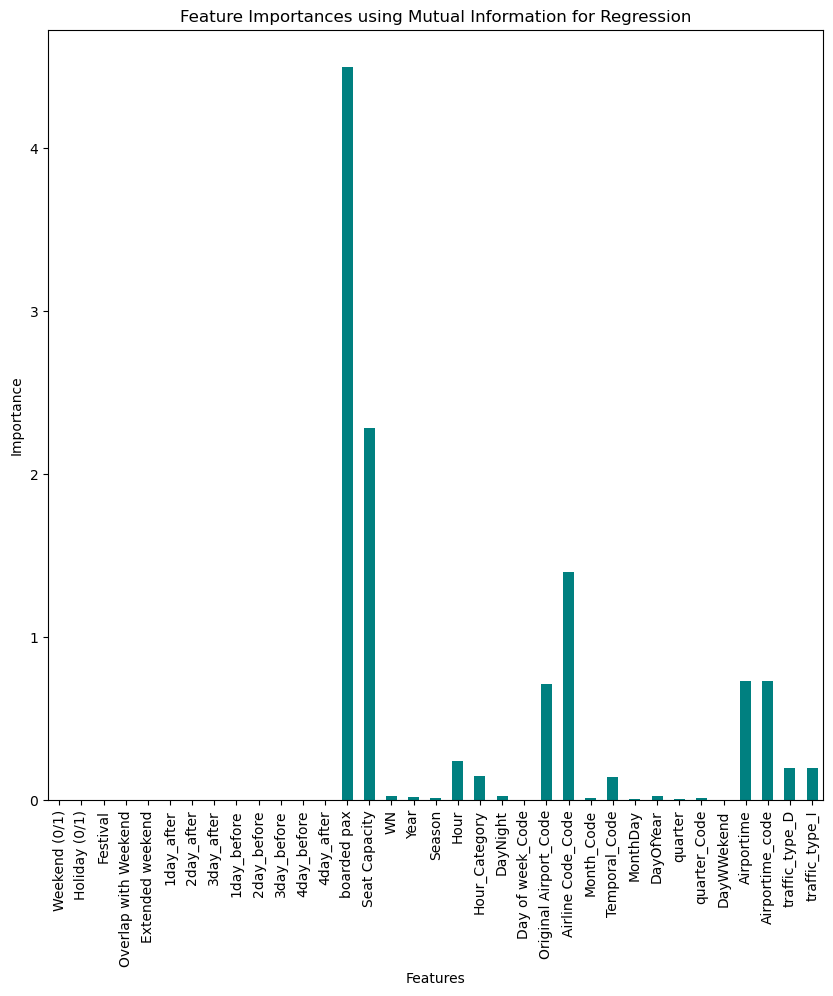

In [29]:
importances = mutual_info_regression(features, label.values.ravel())

# Creating a Series for feature importances
feat_importances = pd.Series(importances, index=features.columns)

# Plotting the feature importances
plt.figure(figsize=(10, 10))
feat_importances.plot(kind='bar', color='teal')
plt.title('Feature Importances using Mutual Information for Regression')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Features with a relatively high Importance that will be used for further Data manipulation are : 
- boarded pax , Seat Capacity , WN , Year , Season , Hour, Hour_Category , DayNight,Original Airport_Code , Airline_Code_Code , Month_Code,Temporal_Code,MonthDay , DayOfYear , quarter , quarter_code,Airporttime, traffic_type_D,traffic_type_I

In [30]:
# New to be considered features
ML_Algarithm = ML_Algarithm[[
    'boarded pax', 'Seat Capacity', 'WN', 'Year', 'Season', 'Hour',
    'Hour_Category', 'DayNight', 'Original Airport_Code', 'Airline Code_Code',
    'Month_Code', 'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter',
    'quarter_Code', 'Airportime_code', 'traffic_type_D', 'traffic_type_I',
    'PAr'
]]

### 2.1 Visualization of Passanger load

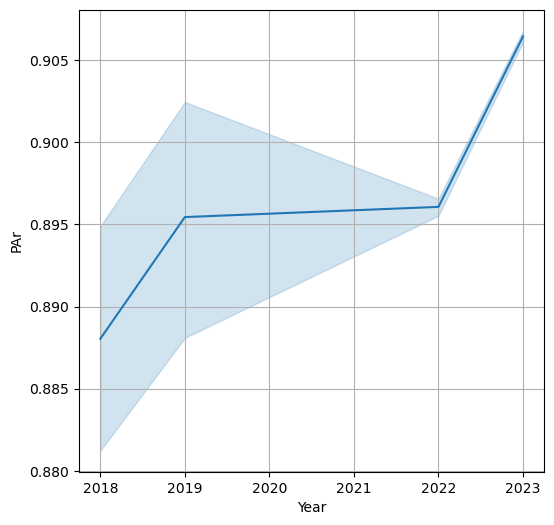

In [31]:
filtered_DF=ML_Algarithm[ML_Algarithm["Year"].isin([2018,2019, 2022, 2023])]
# only includeing years in the DF and removing not needed 
plt.figure(figsize=(6,6))
plt.grid(True)
sns.lineplot(x=filtered_DF['Year'],y=filtered_DF['PAr'])
plt.show()

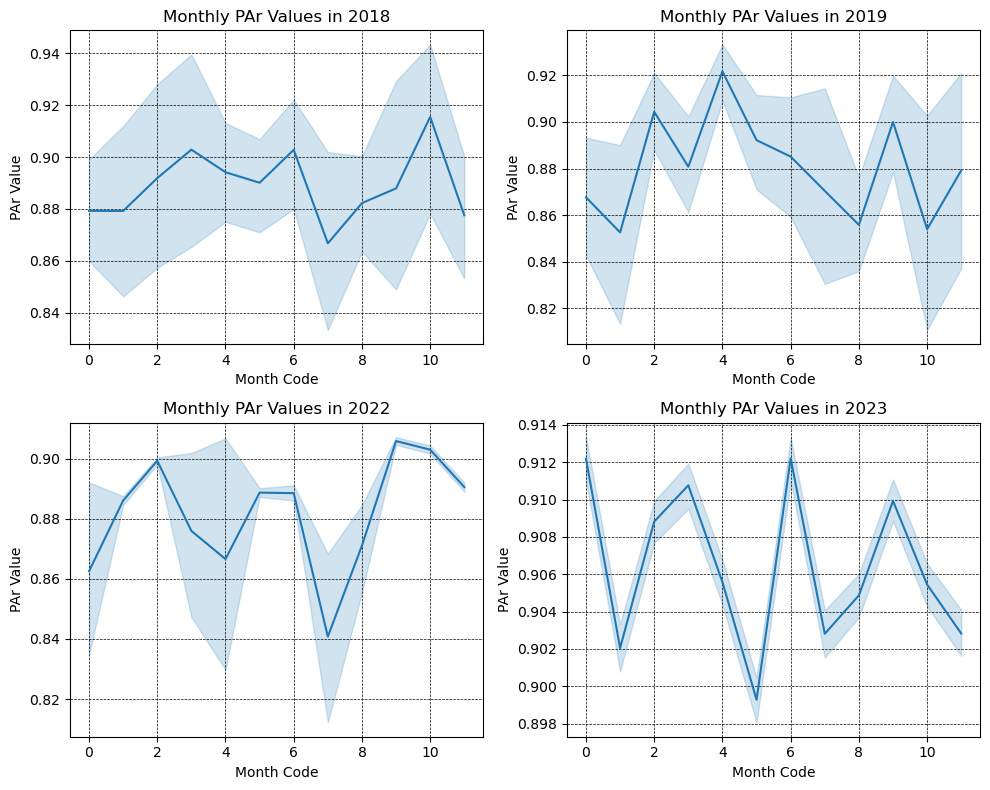

In [32]:
# Create a 2x2 subplot grid
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Extract years to plot
years_to_plot = [2018, 2019, 2022, 2023]

# Iterate through subplots and plot data for each year
for i, year in enumerate(years_to_plot):
    filtered_DF = ML_Algarithm[ML_Algarithm["Year"].isin([year])]
    
    # Calculate subplot position in the 2x2 grid
    row = i // 2
    col = i % 2
    
    # Plotting the line graph on the current subplot
    sns.lineplot(x=filtered_DF['Month_Code'], y=filtered_DF['PAr'], ax=axes[row, col])
    
    # Adding labels to axes
    axes[row, col].set_xlabel('Month Code')
    axes[row, col].set_ylabel('PAr Value')
    
    # Adding a title to the subplot
    axes[row, col].set_title(f'Monthly PAr Values in {year}')
    
    # Changing gridline color to black
    axes[row, col].grid(True, color='black', linestyle='--', linewidth=0.5)

# Adjust layout for better spacing
plt.tight_layout()

# Show the subplots
plt.show()


In [33]:
Y_2018= ML_Algarithm[ML_Algarithm["Year"].isin([2018])]
Y_2019= ML_Algarithm[ML_Algarithm["Year"].isin([2019])]
Y_2022= ML_Algarithm[ML_Algarithm["Year"].isin([2022])]
Y_2023= ML_Algarithm[ML_Algarithm["Year"].isin([2023])]

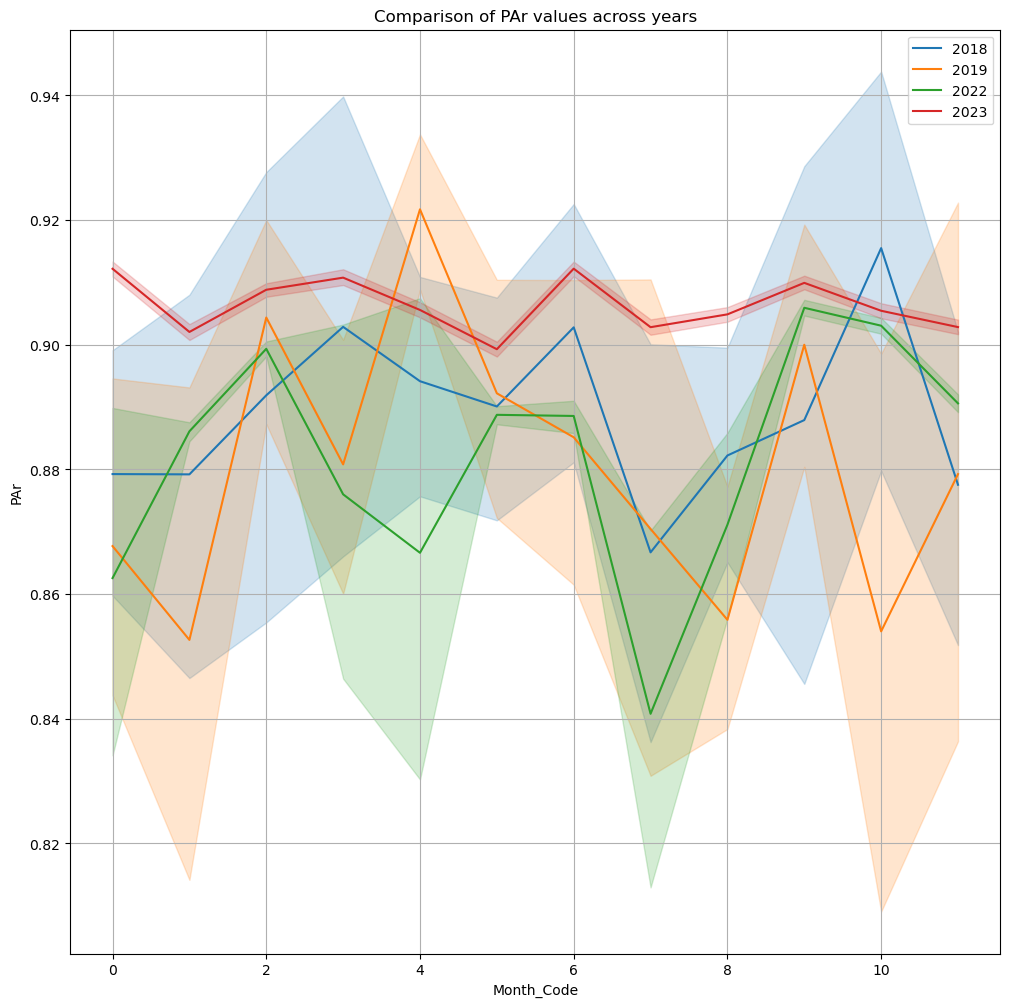

In [34]:
plt.figure(figsize=(12,12))

# Use lineplot for each year
sns.lineplot(x=Y_2018['Month_Code'], y=Y_2018['PAr'], label='2018')
sns.lineplot(x=Y_2019['Month_Code'], y=Y_2019['PAr'], label='2019')
sns.lineplot(x=Y_2022['Month_Code'], y=Y_2022['PAr'], label='2022')
sns.lineplot(x=Y_2023['Month_Code'], y=Y_2023['PAr'], label='2023')

# Add labels to the axes
plt.xlabel('Month_Code')
plt.ylabel('PAr')

# Add a legend to the plot
plt.legend()

# Add a title to the plot
plt.title('Comparison of PAr values across years')

# Add grid
plt.grid(True)

# Show the plot
plt.show()


## 3 Applying the Random-Forest-Regressor

### 3.1 Selection Procedure in terms of Years 
This section involves disecting The Data Set into a Testing and Training Observations

In [35]:
def groupby_Year(df, column_1, column_2):
    '''
  In order to understand how best the Data Frame is to be grouped, I created another function to showcase this total. 
    '''
    gb_Year_pax = df.groupby(column_1).agg({column_2: 'count'})
    gb_Year_pax = gb_Year_pax.sort_values(by=column_2, ascending=False)
    gb_Year_pax = gb_Year_pax.reset_index()
    return gb_Year_pax

In [36]:
gb_Year_pax = groupby_Year(ML_Algarithm,'Year','boarded pax')
gb_Year_pax

,Year,boarded pax
0,2023,141519
1,2022,62236
2,2018,360
3,2019,329


#### Result Interpretation
- The above results mean I will devidie the data set into **2 parts** ,Part of the `´2023 Data will be pushed to the training Data Set .`´ 

In [37]:
Y2018 = ML_Algarithm[ML_Algarithm["Year"] == 2018]
Y2019 = ML_Algarithm[ML_Algarithm["Year"] == 2019]
Y2022 = ML_Algarithm[ML_Algarithm["Year"] == 2022]
Y2023 = ML_Algarithm[ML_Algarithm["Year"] == 2023]
Y2023_training = Y2023[(Y2023["Month_Code"] >= 0) & (Y2023["Month_Code"] <= 8)]
Y2023_testing = Y2023[(Y2023["Month_Code"] >= 9)
                      & (Y2023["Month_Code"] <= 12)]

In [38]:
train_df =pd.concat([Y2018,Y2019,Y2022,Y2023_training]).reset_index(drop=True)
test_df = Y2023_testing

In [39]:
print("Data shape for the training set ",train_df.shape)
print("Data shape for the testing set ",test_df.shape)

Data shape for the training set  (168442, 20)
Data shape for the testing set  (36002, 20)


In [40]:
(len(test_df)/len(train_df))*100 # to be tested results is about 21% 

21.373529167309815

In [41]:
test_df = test_df[[
    'WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
    'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
    'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
    'Airportime_code', 'traffic_type_D', 'traffic_type_I', 'PAr'
]]

In [42]:
train_df = train_df[[
    'WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
    'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
    'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
    'Airportime_code', 'traffic_type_D', 'traffic_type_I', 'PAr'
]]

In [43]:
predictors = train_df[[
    'WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
    'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
    'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
    'Airportime_code', 'traffic_type_D', 'traffic_type_I'
]]
target = train_df[['PAr']]

In [44]:
from sklearn.model_selection import train_test_split

# Split the data into training and cross-validation sets (80-20 split)
x_train, x_cv, y_train, y_cv = train_test_split(predictors, target, test_size=0.2, random_state=42)

# Ensure 'y_train' and 'y_cv' are 1D arrays
y_train = y_train.values.reshape(-1, 1)
y_cv = y_cv.values.reshape(-1, 1)

# Continue with the rest of your code for k-fold cross-validation
num_folds = 10
kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

# Checking the scores by using our function
algos = [LinearRegression, KNeighborsRegressor, RandomForestRegressor, Lasso, ElasticNet, DecisionTreeRegressor]
algorithm_scores = []
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

def scores(algorithm, x_train, y_train, x_cv, y_cv):
    # Initialize the model
    model = algorithm()

    # Train the model on the training set
    model.fit(x_train, y_train)

    # Make predictions on the training set
    y_train_pred = model.predict(x_train)

    # Make predictions on the cross-validation set
    y_cv_pred = model.predict(x_cv)

    # Calculate R-squared scores
    train_score = r2_score(y_train, y_train_pred)
    cv_score = r2_score(y_cv, y_cv_pred)

    # Calculate Mean Squared Error
    mean_error_train = mean_squared_error(y_train, y_train_pred)
    mean_error_cv = mean_squared_error(y_cv, y_cv_pred)
    
    # Calculate the Adjusted R-sqaured scores 
    train_score_adjusted_r_squared = 1 - (1 - train_score) * (len(y_train) - 1) / (len(y_train) - x_train.shape[1] - 1)

    return train_score, train_score_adjusted_r_squared,cv_score, mean_error_cv

for algo in algos:
    avg_train_score, train_score_adjusted_r_squared, avg_cv_score, avg_mean_error = scores(algo, x_train.values, y_train, x_cv.values, y_cv)
    algorithm_scores.append((algo.__name__, avg_train_score, train_score_adjusted_r_squared, avg_cv_score, avg_mean_error))
    print(f'{algo.__name__} Average Training R-squared score: {avg_train_score}')
    print(f'{algo.__name__} Average Adjusted Training R-squared score: {train_score_adjusted_r_squared}')
    print(f'{algo.__name__} Average Cross-Validation R-squared score: {avg_cv_score}')
    print(f'{algo.__name__} Average Mean Error: {avg_mean_error}')

# Optionally, you can print or analyze the scores
print("Algorithm Scores:")
for algo_name, avg_train_score, train_score_adjusted_r_squared, avg_cv_score, avg_mean_error in algorithm_scores:
    print(f'{algo_name}:')
    print(f'  Average Training Score: {avg_train_score}')
    print(f'  Adjusted Training R-squared score: {train_score_adjusted_r_squared}')
    print(f'  Average Cross-Validation Score: {avg_cv_score}')
    print(f'  Average Mean Error: {avg_mean_error}')


LinearRegression Average Training R-squared score: 0.00824782049842987
LinearRegression Average Adjusted Training R-squared score: 0.008122687555604857
LinearRegression Average Cross-Validation R-squared score: 0.007176683976377274
LinearRegression Average Mean Error: 0.004563194798977069
KNeighborsRegressor Average Training R-squared score: 0.29938643607477866
KNeighborsRegressor Average Adjusted Training R-squared score: 0.29929803713918857
KNeighborsRegressor Average Cross-Validation R-squared score: -0.059237574975528506
KNeighborsRegressor Average Mean Error: 0.004868446696405355


C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor Average Training R-squared score: 0.8762616310002256
RandomForestRegressor Average Adjusted Training R-squared score: 0.876246018484747
RandomForestRegressor Average Cross-Validation R-squared score: 0.2459443359516672
RandomForestRegressor Average Mean Error: 0.0034657756609764003
Lasso Average Training R-squared score: 0.0
Lasso Average Adjusted Training R-squared score: -0.0001261736000297553
Lasso Average Cross-Validation R-squared score: -7.816535341387265e-05
Lasso Average Mean Error: 0.0045965393933220695
ElasticNet Average Training R-squared score: 0.0
ElasticNet Average Adjusted Training R-squared score: -0.0001261736000297553
ElasticNet Average Cross-Validation R-squared score: -7.816535341387265e-05
ElasticNet Average Mean Error: 0.0045965393933220695
DecisionTreeRegressor Average Training R-squared score: 0.9750404983573651
DecisionTreeRegressor Average Adjusted Training R-squared score: 0.9750373491271879
DecisionTreeRegressor Average Cross-Validation

- As I have have evaluated, the ` Random-Forest-Regressor´`´ will be the best algorithm for our given dataset. So let’s run it and see, how it performs.It  has the lowest Average Mean Error of **0.0034732446088056135**as compared to other options. 

### 3.2 The Random Forest Regressor is being implemented here 

In [45]:
#Hypertuned Model
model = RandomForestRegressor(n_estimators=50, oob_score = True,n_jobs=3,random_state =42, min_samples_leaf =8,max_depth=4)
# in this case the program is running an amount of 10 trees 
# gini criterion : They are specifically choosen to maximize the information gain at each step 
#max sample of 0.5 means it will draw random subsamples with size equal to half of the training entire set . 

In [46]:
# Fitting the model on the training Data 
model.fit(x_train,y_train)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestRegressor(max_depth=4, min_samples_leaf=8, n_estimators=50,
                      n_jobs=3, oob_score=True, random_state=42)

### 3.3 Showing the Trees created

In [47]:
trees = model.estimators_
# Print the first tree for example
print(trees[0])

DecisionTreeRegressor(max_depth=4, max_features=1.0, min_samples_leaf=8,
                      random_state=1608637542)


In [48]:
predictors.columns

Index(['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I'],
      dtype='object')

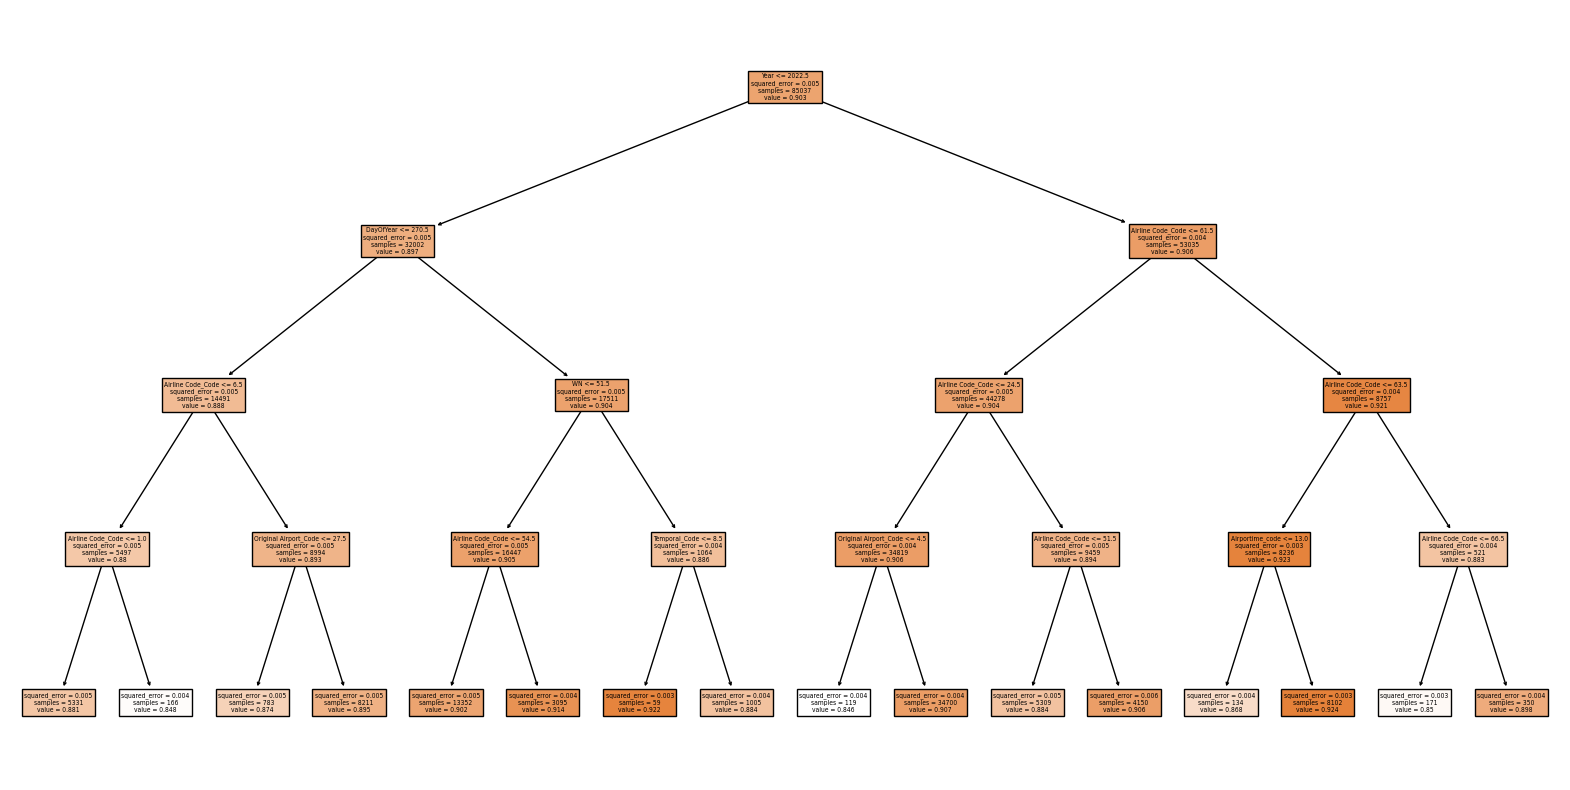

In [49]:
from sklearn.tree import plot_tree

feature_names = ['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I']

# Plot the first tree for example
plt.figure(figsize=(20, 10))
plot_tree(model.estimators_[0], filled=True, feature_names=feature_names)
plt.show()

In [50]:
test=test_df
test=test_df[['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I']]

In [51]:
test.columns

Index(['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I'],
      dtype='object')

In [52]:
pred=model.predict(test) # it is combining the other parameters and making decisions . 

In [53]:
test.loc[:,"Predicted PAr"]=pred.round(6)

### 3.4 Merging both values using shared columns : 
- This section merges columns using the inner join function in order for us to study further how the model performas.

In [54]:
test_predict = pd.merge(test,
                        test_df,
                        on=[
                            'WN', 'Year', 'Season', 'Hour', 'Hour_Category',
                            'DayNight', 'Original Airport_Code',
                            'Airline Code_Code', 'Month_Code', 'Temporal_Code',
                            'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
                            'Airportime_code', 'traffic_type_D',
                            'traffic_type_I'
                        ],
                        how="inner")

In [55]:
mse= mean_squared_error(test_predict["PAr"], test_predict["Predicted PAr"])
print(f'MSE: {mse}')

MSE: 0.0042848810513491


In [56]:
print("in terms of percentage , the Mean squared error is : ",  mse*100)

in terms of percentage , the Mean squared error is :  0.42848810513491004


## 4  post-processing Technique to reduce the MAE of the model: 
 The goal of this technique is to balance out the high differences between the predicted and actualy pAr differences. 
 The adjustment is applied to the predicted values (Predicted PAr) based on the mean difference between the predicted and    actual values. The goal is to iteratively refine the predictions so that the mean absolute error (MAE) between the adjusted predictions and the actual values becomes closer to the target MAE.

In [57]:
test_predict["Difference"]=test_predict["Predicted PAr"]-test_predict["PAr"]

## 4.1 Applying the Mininimize post Machine Learning Algarithm

In [58]:
from scipy.optimize import minimize_scalar

# Calculate the mean of the differences
mean_difference = test_predict['Difference'].mean()

# Initial evaluation
mae_original = mean_absolute_error(test_predict['PAr'], test_predict['Predicted PAr'])

# Define the objective function for optimization
def objective_function(adjustment_value):
    adjusted_predictions = test_predict['Predicted PAr'] + adjustment_value * mean_difference
    return mean_absolute_error(test_predict['PAr'], adjusted_predictions)

# Use optimization to find the optimal adjustment value
result = minimize_scalar(objective_function)
optimal_adjustment_value = result.x

# Adjust the predicted values with the optimal adjustment value
test_predict['Optimal Adjusted Predicted PAr'] = test_predict['Predicted PAr'] + optimal_adjustment_value * mean_difference

# Evaluate the performance of the adjusted predictions
mae_optimal_adjusted = mean_absolute_error(test_predict['PAr'], test_predict['Optimal Adjusted Predicted PAr'])

print(f'Optimal Adjustment Value: {optimal_adjustment_value}')
print(f'MAE (Optimal Adjusted Predictions): {mae_optimal_adjusted}')


Optimal Adjustment Value: -1813.7008032326082
MAE (Optimal Adjusted Predictions): 0.05416163865418157


In [59]:
Not_adjusted_mae=mean_absolute_error(test_predict["PAr"],test_predict['Predicted PAr'])
predicted_mea_optimal=mean_absolute_error(test_predict["PAr"],test_predict['Optimal Adjusted Predicted PAr'])

In [60]:
percentage_increase = ((predicted_mea_optimal - Not_adjusted_mae) / Not_adjusted_mae) * 100
print("Iterative process, absolute error has been increased by:", percentage_increase,"%")

Iterative process, absolute error has been increased by: -1.6102928497273974 %


Improving the Model via the **minimize_scalar** has failed to improve the model  , the negative value increase of `´- 1.6102928497273974`´ indicates that implementing this minimizer function has improved the model by a certain small percentage.

In [61]:
def time_interval_convert(x):
    x = int(x)  
    if x == 920:
        return "9 am | 8 pm"
    elif x == 822:
        return "8 am | 10 pm"
    elif x == 1023:
        return "10 am | 11 pm"
    elif x == 1821:
        return "6 pm | 9 pm"
    elif x == 1216:
        return "12 MD | 4 pm"
    elif x == 1419:
        return "2 pm | 7 pm"
    elif x == 1117:
        return "11 am | 5 pm"
    elif x == 1315:
        return "1 pm | 3 pm"
    elif x == 10:
        return "12 MN | 1 am"
    elif x == 27:
        return "2 am | 7 am"
    elif x == 34:
        return "3 am | 4 am"
    else:
        return "5 am | 6 am"

### Reverting back the season Feature

In [62]:
def Seasons_revert(Month):
    if Month == 1:
        return "October or December"
    elif Month == 2:
        return "September or August"
    elif Month == 3:
        return "June or January"
    elif Month == 4:
        return "March or February"
    elif Month == 5:
        return "May or April"
    else:
        return "July or November"

In [63]:
test_predict["Season Name"]=test_predict["Season"].apply(Seasons_revert)

### Week Code conversion

  
# <span style='color:green'>Model Improvement </span>
XGBoost provides built-in support for L1 (Lasso) and L2 (Ridge) regularization, which helps prevent overfitting by penalizing complex models. Random Forest, while having mechanisms to combat overfitting like bootstrapping and feature randomization, does not have the same level of explicit regularization.

XGBoost is an implementation of gradient boosting, which builds trees sequentially, each correcting errors made by the previous ones. This can lead to a more precise and accurate model.Random Forest, on the other hand, builds trees independently and combines their predictions through averaging (classification) or averaging-weighted voting (regression).

## 5. Using the XGBoost and GridSearch Algarithm

In [64]:
print("Shape of our training Data Set " , train_df.shape)
print("Shape is of the testing Data Set:" ,test_df.shape)

Shape of our training Data Set  (168442, 18)
Shape is of the testing Data Set: (36002, 18)


In [65]:
from xgboost import plot_importance, plot_tree
from warnings import filterwarnings
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(20,10) # for graphs styling
plt.style.use('tableau-colorblind10') # for graph stying

In [66]:
train_df.columns

Index(['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I', 'PAr'],
      dtype='object')

In [67]:
X_train=train_df[['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I']]
y_train=train_df[['PAr']]

In [68]:
X_test=test_df[['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I']]
y_test=test_df[['PAr']]

In [69]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error
import xgboost as xgb
import numpy as np

# A parameter grid for XGBoost
params = {
    'min_child_weight': [5],# [4, 5,6]
    'gamma': [0.01],# it was initially on a longer range 
    'subsample': [0.4],
    'colsample_bytree': [0.4],#[i / 10.0 for i in range(3, 5)]
    'max_depth': [5],
    'learning_rate': [0.2],# Without many constrains, the model can quickly fit or over fit hence reducing its possiblity through the learning rate . 
    'n_estimators': [150],
    'reg_alpha': [0, 0.001, 0.01, 0.1, 1, 10],# Increasing this value will make the model more conservative L2 regularization on weights 
    'reg_lambda': [0, 0.001, 0.01, 0.1, 1, 10],# L1 regularization term on weights .. 
    'scale_pos_weight': [1]  
    #max_features='sqrt'
}

# Initialize XGB
xgb_reg = xgb.XGBRegressor(nthread=-1, objective='reg:squarederror')

# Set up KFold cross-validation with k=5
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with cross-validation
grid = GridSearchCV(xgb_reg, params, cv=kfold)
grid.fit(X_train, y_train)

# Get the best estimator from GridSearchCV
gridcv_xgb = grid.best_estimator_

# Predict on the test set
y_pred = gridcv_xgb.predict(X_test)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print(f'R2 Score: {r2}')

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

# Additional Information: Print the best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid.best_params_)

print(r2_score(y_test, gridcv_xgb.predict(X_test)))

R2 Score: 0.11241352688801176
Mean Absolute Error: 0.05237221905171795
Best Hyperparameters: {'colsample_bytree': 0.4, 'gamma': 0.01, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 150, 'reg_alpha': 0.01, 'reg_lambda': 0.1, 'scale_pos_weight': 1, 'subsample': 0.4}
0.11241352688801176


In [70]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_absolute_error

# Initialize XGBRegressor with the best hyperparameters
best_xgb_model = xgb.XGBRegressor(
    min_child_weight=gridcv_xgb.min_child_weight,
    gamma=gridcv_xgb.gamma,
    subsample=gridcv_xgb.subsample,
    colsample_bytree=gridcv_xgb.colsample_bytree,
    max_depth=gridcv_xgb.max_depth,
    learning_rate=gridcv_xgb.learning_rate,
    n_estimators=gridcv_xgb.n_estimators,
    scale_pos_weight=gridcv_xgb.scale_pos_weight,
    reg_alpha=gridcv_xgb.reg_alpha,
    reg_lambda=gridcv_xgb.reg_lambda,
    
    nthread=-1,
    objective='reg:squarederror'
)

# Train the model on the entire training dataset
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Evaluate the performance of the final model
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f'Final R2 Score: {r2}')
print(f'Final Mean Absolute Error: {mae}')

Final R2 Score: 0.11241352688801176
Final Mean Absolute Error: 0.05237221905171795


In [71]:
X_test['Predicted PAr'] = y_pred

## 5.1 Feature Importances
- This is a metric that simply sums up how many times each feature is split on.
- It shows that Week Number was used so much often to split the trees, followed by the TIntervals and lastly the Seasons 

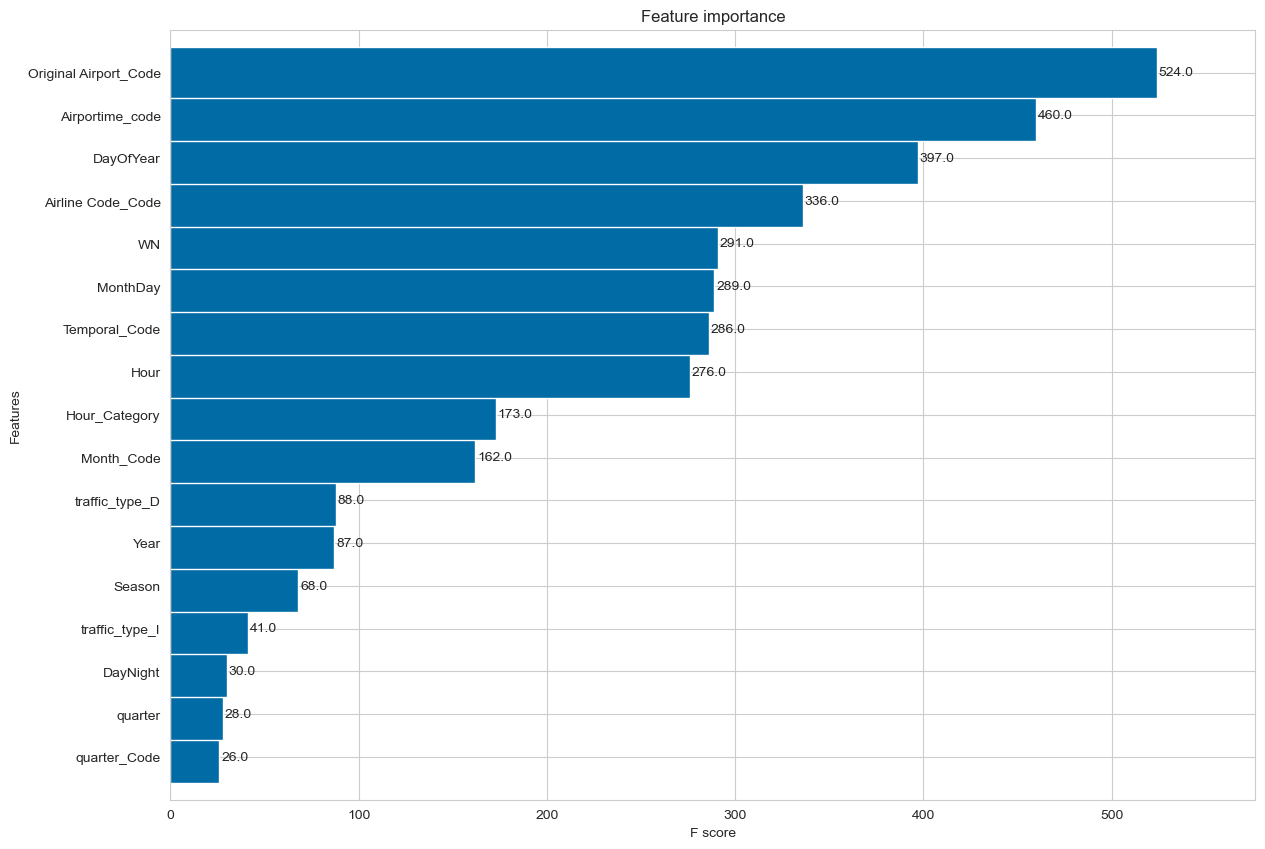

In [72]:
from xgboost import plot_importance
plt.rcParams["figure.figsize"] = (14,10)
plot_importance(best_xgb_model, height=1.2)
plt.show()

In [73]:
merged_results = pd.merge ( test_df,X_test , on = ['WN', 'Year', 'Season', 'Hour', 'Hour_Category', 'DayNight',
       'Original Airport_Code', 'Airline Code_Code', 'Month_Code',
       'Temporal_Code', 'MonthDay', 'DayOfYear', 'quarter', 'quarter_Code',
       'Airportime_code', 'traffic_type_D', 'traffic_type_I'],how = 'inner')

In [74]:
xgboost_mae = mean_absolute_error(merged_results["PAr"], merged_results["Predicted PAr"])
print("Mean Absolute Error for XGBoost algorithm is:", xgboost_mae)

random_forest_mae = mean_absolute_error(test_predict["PAr"], test_predict["Predicted PAr"])
print("Mean Absolute Error for RandomForestRegressor algorithm is:", random_forest_mae)

percentage_improvement = ( (xgboost_mae - random_forest_mae)/xgboost_mae)*100
print(f"The percentage improvement through switching from Random Forest to XGBoost algorithm is: {percentage_improvement:.2f}%")

Mean Absolute Error for XGBoost algorithm is: 0.052363852979829935
Mean Absolute Error for RandomForestRegressor algorithm is: 0.055048073851322064
The percentage improvement through switching from Random Forest to XGBoost algorithm is: -5.13%


Having employed the minimizer function aka MAE, we got the Optimal Adjusted Predictions of **0.05416163865418157**

The results above indicate that through the implementation of the xgboost algarithm , the model performance was increased by 5.13% as compared to the Minimizer function implementation . For that matter, The xgboost algarithm offers a better handling ability . 